In [1]:
import os 

import numpy as np  
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import train_models
import model_
import plotting 

/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


## Train a context aware model 

Use probabilities from classifier, LDA topics and metadata / context data. Goal is to build an interpretable model.

In [51]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v4.csv")

print(df.columns)

Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')


In [52]:
context_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']


def run_all_cls(df, features, feature_type):
    model_types = ["NB", "KNN", "XGB"]
    
    m_res_df = None 
    m_probs_df = None 
    for model_type in model_types:
        res_df, prob_df = train_models.train_n_cv_valid_models(df, features, model_type)
        
        if m_res_df is None:
            m_res_df = res_df 
        else:
            m_res_df = pd.concat([m_res_df, res_df], axis=0).copy()
            
            
        if m_probs_df is None:
            m_probs_df = prob_df 
        else:
            m_probs_df = pd.merge(m_probs_df, prob_df, on=["ID"], sort=True)
            
        # save the probabilities to disk 
    to_save_filename = "probs" + "_" + feature_type + ".csv"
    m_probs_df.to_csv(os.path.join("../data/cls_pred_files", to_save_filename), index=False, header=True)
            
    m_res_df = m_res_df[m_res_df["metrics_names"].isin(["support"]) == False].copy()
    m_res_df = m_res_df.rename(columns={"0": "Antimask", "1": "Promask"})
    
    return m_res_df.reset_index()


feature_type = "context"
res_df = run_all_cls(df, context_features, feature_type)

res_df.head()

[1, 2, 3, 4]
[1, 2, 3, 4]
[1, 2, 3, 4]


index  Antimask   Promask  accuracy macro avg weighted avg metrics_names  \
0      0  0.562791  0.677419     0.585  0.620105     0.618242     precision   
1      1  0.878935  0.271318     0.585  0.575126        0.585        recall   
2      2    0.6862  0.387454     0.585  0.536827     0.541682      f1-score   
3      4  0.535664   0.72093  0.555556  0.628297     0.626794     precision   
4      5  0.941032   0.15736  0.555556  0.549196     0.555556        recall   

  cls_model_name  
0             NB  
1             NB  
2             NB  
3             NB  
4             NB

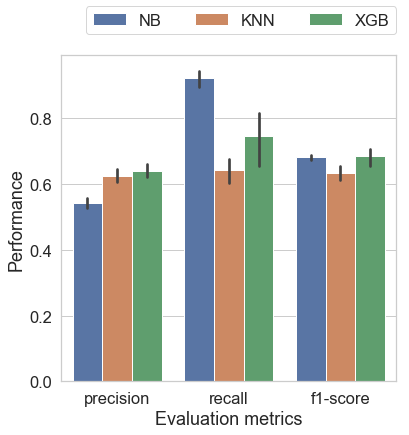

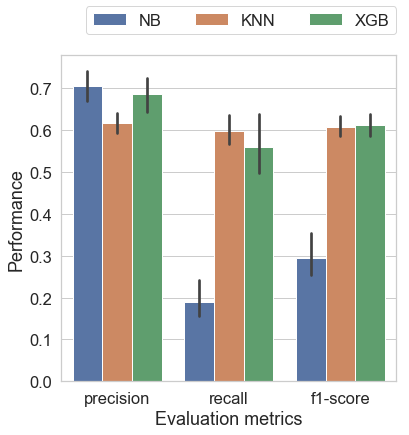

In [53]:
# def get_res_summ(res_df):
#     res_df2 = res_df[["0", "1", "accuracy", "metrics_names", "cls_model_name"]]
#     res_df2[["0", "1", "accuracy"]] = res_df2[["0", "1", "accuracy"]].astype({'0': 'float32', '1':'float32', 'accuracy':'float32'})

#     res_df2 = res_df2.groupby(by=["cls_model_name", "metrics_names"])
#     print(res_df2.mean())
#     return res_df2.mean(), res_df2.std()
    


def plot_res_n_save(df, wrt_fig_dir, feature_type):
    x = "metrics_names"
    types = ["Antimask", "Promask"]
    h = "cls_model_name" 
    xAxis_label = "Evaluation metrics"
    yAxis_label = "Performance"

    for y in types:
        plotting.bar_plot(x, y, h, df, xAxis_label, yAxis_label)
        
        plt_name = "cls_res_" + y + "_" + feature_type + ".jpg"
        plt.savefig(os.path.join(wrt_fig_dir, plt_name),
                    bbox_inches = 'tight', # get rid of the white space
                    pad_inches = 0.05, # ref: https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib/27227718
                    dpi=300)
        plt.show()


    return 0 

feature_type = "context"
_ = plot_res_n_save(res_df, "../figs/cls_perfs/", feature_type)

## Train model on BERT Features 

In [54]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v4.csv")

print(df.columns)


BERT_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_BERT_df_v4.csv")
print(BERT_df.shape)

Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')
(3201, 769)


In [55]:
merged_df = pd.merge(df[["ground_truth", "folds", "ID"]], BERT_df, on=["ID"], sort=True)

merged_df.shape

(3201, 771)

In [56]:
print(merged_df.shape)

BERT_features = BERT_df.columns.tolist()[:-1]


feature_type = "BERT"
res_df = run_all_cls(merged_df, BERT_features, feature_type)

res_df.head()

(3201, 771)
[1, 2, 3, 4]
[1, 2, 3, 4]
[1, 2, 3, 4]


index  Antimask   Promask  accuracy macro avg weighted avg metrics_names  \
0      0  0.962353  0.989333     0.975  0.975843     0.975405     precision   
1      1  0.990315  0.958656     0.975  0.974486        0.975        recall   
2      2  0.976134  0.973753     0.975  0.974943     0.974982      f1-score   
3      4  0.943794  0.989305  0.965044  0.966549      0.96618     precision   
4      5  0.990172  0.939086  0.965044  0.964629     0.965044        recall   

  cls_model_name  
0             NB  
1             NB  
2             NB  
3             NB  
4             NB

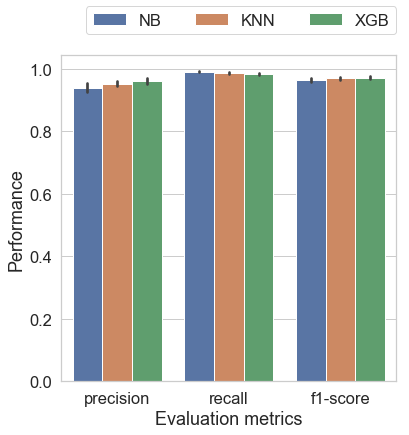

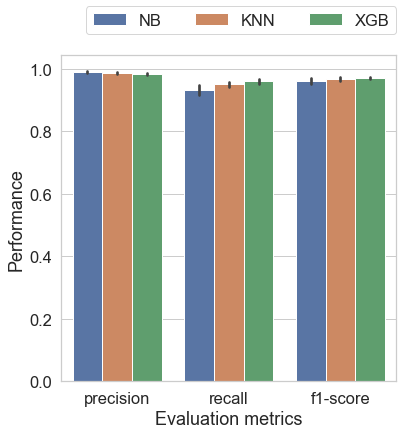

In [57]:
# res_df = get_res_summ(res_df)

# print(res_df)

feature_type = "BERT"
_ = plot_res_n_save(res_df, "../figs/cls_perfs/", feature_type)

## Train model on TF-IDF features - CANCELED 

In [5]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v3.csv")

print(df.columns)


TF_IDF_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_TF_IDF_df_v4.csv")
print(TF_IDF_df.shape)

Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')
(3201, 12019)


In [ ]:
merged_df = pd.merge(df[["ground_truth", "folds", "ID"]], TF_IDF_df, on=["ID"], sort=True)

In [ ]:
print(merged_df.shape)

TF_IDF_features = TF_IDF_df.columns.tolist()[:-1]

model_type = "XGB"
res_df = train_models.train_n_cv_valid_models(merged_df, TF_IDF_features, model_type)

## K-means model 

In [5]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v4.csv")

n_comps_LDA_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_LDA10_df_v4.csv")

cls_probs_df = pd.read_csv("../data/cls_pred_files/probs_BERT.csv")

print(df.columns)
print(n_comps_LDA_df.columns)
print(cls_probs_df.columns)

Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')
Index(['LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3', 'LDA_comp_4', 'LDA_comp_5',
       'LDA_comp_6', 'LDA_comp_7', 'LDA_comp_8', 'LDA_comp_9', 'LDA_comp_10',
       'ID'],
      dtype='object')
Index(['NB_prob0', 'NB_prob1', 'ID', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0',
       'XGB_prob1'],
      dtype='object')


In [6]:
# merged_df = pd.merge(df, n_comps_LDA_df, on=["ID"], sort=True)

merged_df = pd.merge(df, n_comps_LDA_df, on=["ID"], sort=True)
merged_df = pd.merge(merged_df, cls_probs_df, on=["ID"], sort=True)

print(merged_df.shape)
print(merged_df.columns)

(3201, 40)
Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3', 'LDA_comp_4', 'LDA_comp_5',
       'LDA_comp_6', 'LDA_comp_7', 'LDA_comp_8', 'LDA_comp_9', 'LDA_comp_10',
       'NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0',
       'XGB_prob1'],
      dtype='object')


In [7]:
# context_n_LDA_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 
#                           'vader_pos', 'vader_compound'] + n_comps_LDA_df.columns.tolist()[:-1]

# print(context_n_LDA_features)


def min_max_norm(X):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    return scaler.fit_transform(X), scaler.transform(X)
    

def get_kmeans_res(df, features):
    n_clusters = [2, 3, 4, 5, 7, 10]
    n_clusters = list(range(2, 30, 1))

    best_nc = None 
    best_nc_score = 0 
    best_nc_labels = None 
    for nc in n_clusters:
    #     print("Number of clusters:", nc)
        norm_df, _= min_max_norm(df[features].astype(float))
        k_means_model = model_.kmeans_clustering(norm_df, nc)

        labels = k_means_model.predict(norm_df)

        score = silhouette_score(norm_df, labels)
        print("Silhouette score:", score)

        if score > best_nc_score:
            best_nc = nc 
            best_nc_score = score 
            best_nc_labels = labels

    print(f'Number of clusters: {best_nc} with best score {best_nc_score}')
        
    return best_nc, best_nc_score, best_nc_labels



stacked_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 
                          'vader_pos', 'vader_compound'] \
                    + n_comps_LDA_df.columns.tolist()[:-1] \
                    + ['NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0', 'XGB_prob1'] 

best_nc, best_nc_score, best_nc_labels = get_kmeans_res(merged_df, stacked_features)

Silhouette score: 0.7382394618734027
Silhouette score: 0.5453775721200642
Silhouette score: 0.32838579428614756
Silhouette score: 0.3539497160252177
Silhouette score: 0.3635183772391313
Silhouette score: 0.39338455301643194
Silhouette score: 0.4142146977669768
Silhouette score: 0.41680999427816257
Silhouette score: 0.4164224882814139
Silhouette score: 0.419212595175591
Silhouette score: 0.4081074151094011
Silhouette score: 0.41273872185715293
Silhouette score: 0.4017707654808678
Silhouette score: 0.40683099756545915
Silhouette score: 0.4031417488683432
Silhouette score: 0.4098066934746943
Silhouette score: 0.4091679358771249
Silhouette score: 0.411519866068065
Silhouette score: 0.39738953293864326
Silhouette score: 0.41799951745237135
Silhouette score: 0.39920083354178776
Silhouette score: 0.40486305181728244
Silhouette score: 0.4152871646021283
Silhouette score: 0.41313047277483145
Silhouette score: 0.40951329370629114
Silhouette score: 0.4007709694182837
Silhouette score: 0.404224579

In [17]:
np.sum(best_nc_labels)

1698

In [18]:
# labels = k_means_model.predict(merged_df[context_n_LDA_features])

NameError: name 'k_means_model' is not defined

In [19]:
# labels.shape

NameError: name 'labels' is not defined

## t-SNE, UMAP and other visualization 

In [10]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v4.csv")

n_comps_LDA_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_LDA10_df_v4.csv")

cls_probs_df = pd.read_csv("../data/cls_pred_files/probs_BERT.csv")

print(df.columns)
print(n_comps_LDA_df.columns)
print(cls_probs_df.columns)

Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')
Index(['LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3', 'LDA_comp_4', 'LDA_comp_5',
       'LDA_comp_6', 'LDA_comp_7', 'LDA_comp_8', 'LDA_comp_9', 'LDA_comp_10',
       'ID'],
      dtype='object')
Index(['NB_prob0', 'NB_prob1', 'ID', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0',
       'XGB_prob1'],
      dtype='object')


In [11]:
merged_df = pd.merge(df, n_comps_LDA_df, on=["ID"], sort=True)
merged_df = pd.merge(merged_df, cls_probs_df, on=["ID"], sort=True)

print(merged_df.shape)
print(merged_df.columns)

(3201, 40)
Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3', 'LDA_comp_4', 'LDA_comp_5',
       'LDA_comp_6', 'LDA_comp_7', 'LDA_comp_8', 'LDA_comp_9', 'LDA_comp_10',
       'NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0',
       'XGB_prob1'],
      dtype='object')


In [15]:
def grid_search_UMAP_params(df, features, labels):
    # n_neigh = 200
    # min_dist = 0.99
    n_neighs = list(range(10, 200, 30))
    min_dists = [0.1, 0.3, 0.5, 0.7, 0.8, 0.95]
    
    norm_df, _ = min_max_norm(df[features])

    for n_neigh in n_neighs:
        for m_dist in min_dists:
#             if target_n_neigh == n_neigh and target_m_dist == target_m_dist: # to do a grid search - comment out this line of code
            print("\n" + "=" * 100)
            print(f'Number of neighbors: {n_neigh}, minimum distance: {m_dist}')
            n_comps_UMAP = model_.umap_(norm_df, n_neigh, m_dist)

            plt.clf()
            sns.scatterplot(n_comps_UMAP[:, 0], n_comps_UMAP[:, 1], hue=labels)
            plt.show()
            
    return 0 


def get_UMAP_w_fixed_params(df, features, n_neigh, min_dist, labels):
    norm_df, _ = min_max_norm(df[features])
    n_comps_UMAP_mat = model_.umap_(norm_df, n_neigh, min_dist)

    plt.clf()
    sns.scatterplot(n_comps_UMAP_mat[:, 0], n_comps_UMAP_mat[:, 1], hue=labels)
    plt.show()
    
    return pd.DataFrame(n_comps_UMAP_mat, columns=["comp_1", "comp_2"])


def plot_latent_space(df, h, wrt_fig_dir, plt_name):
    x = "comp_1" 
    y = "comp_2" 
    xAxis_label, yAxis_label = "Component 1", "Component 2" 
    
    plotting.scatter_plot(x, y, h, df, xAxis_label, yAxis_label)

    plt.savefig(os.path.join(wrt_fig_dir, plt_name),
                bbox_inches = 'tight', # get rid of the white space
                pad_inches = 0.05, # ref: https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib/27227718
                dpi=300)
    plt.show()
    
    return 0 


#### UMAP and K-means results 


Number of neighbors: 10, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


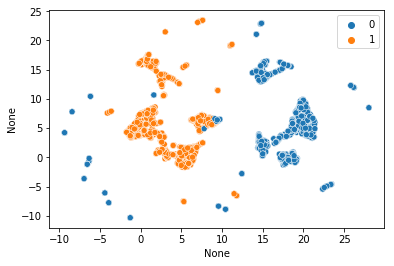


Number of neighbors: 10, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


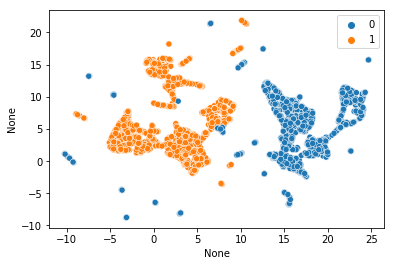


Number of neighbors: 10, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


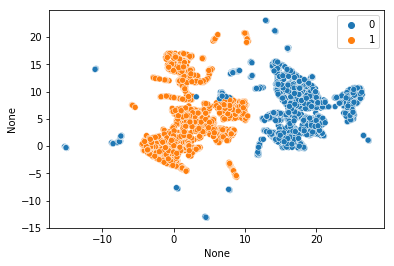


Number of neighbors: 10, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


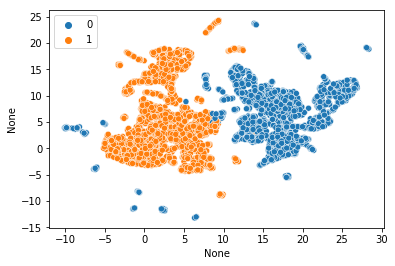


Number of neighbors: 10, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


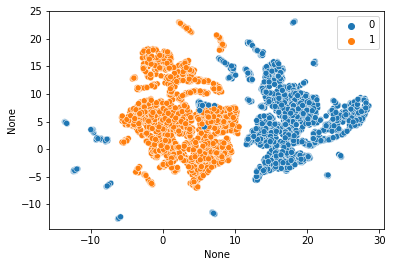


Number of neighbors: 10, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


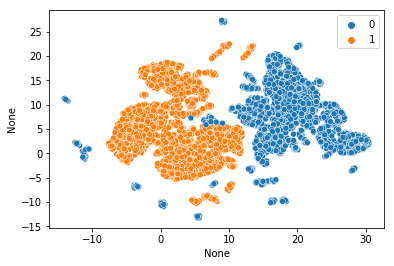


Number of neighbors: 40, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


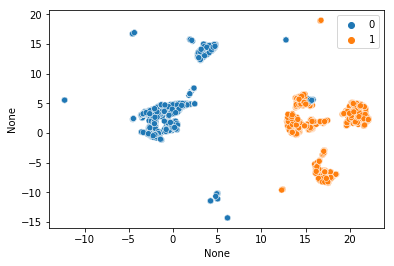


Number of neighbors: 40, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


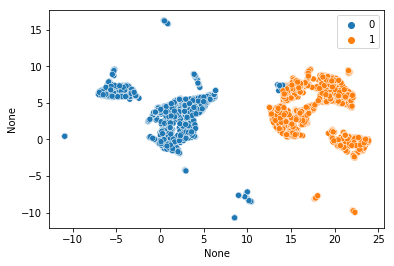


Number of neighbors: 40, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


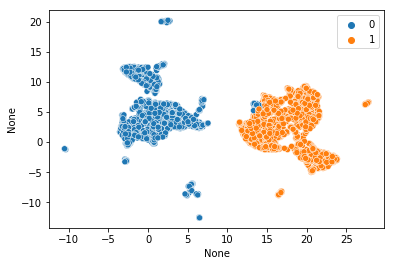


Number of neighbors: 40, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


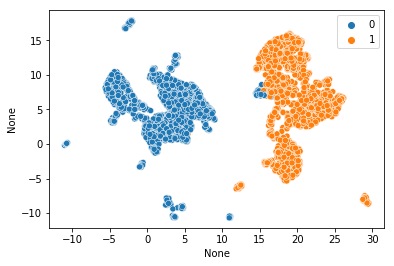


Number of neighbors: 40, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


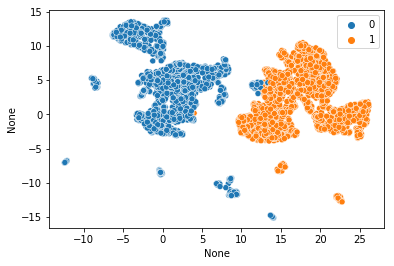


Number of neighbors: 40, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


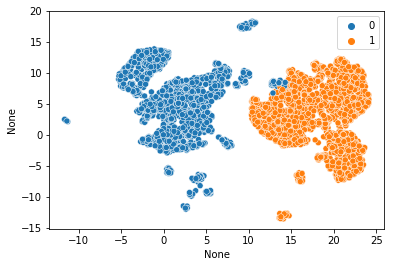


Number of neighbors: 70, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


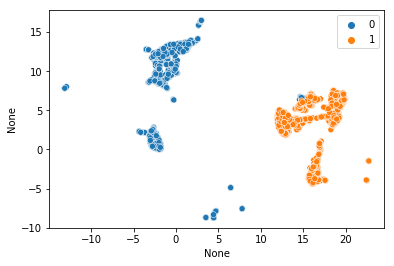


Number of neighbors: 70, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


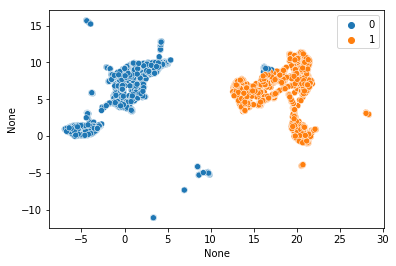


Number of neighbors: 70, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


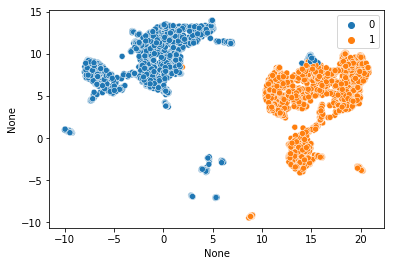


Number of neighbors: 70, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


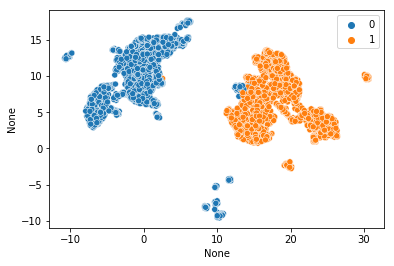


Number of neighbors: 70, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


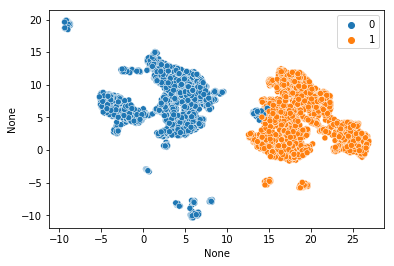


Number of neighbors: 70, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


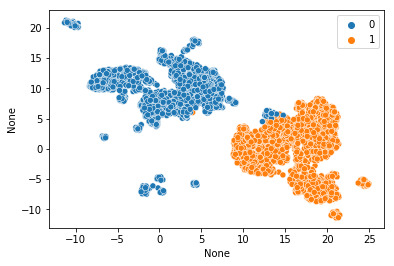


Number of neighbors: 100, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


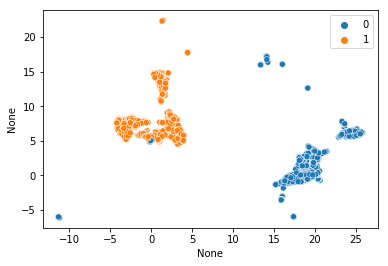


Number of neighbors: 100, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


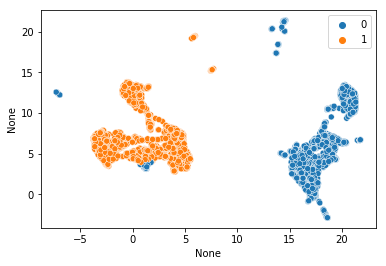


Number of neighbors: 100, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


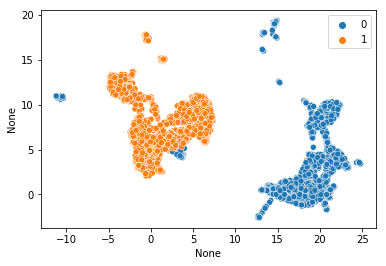


Number of neighbors: 100, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


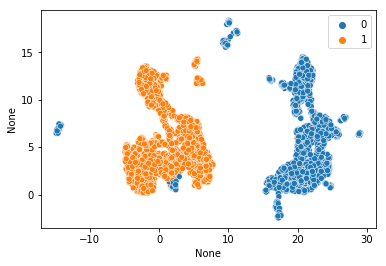


Number of neighbors: 100, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


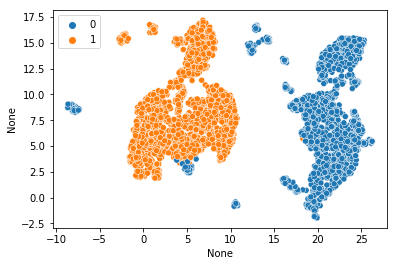


Number of neighbors: 100, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


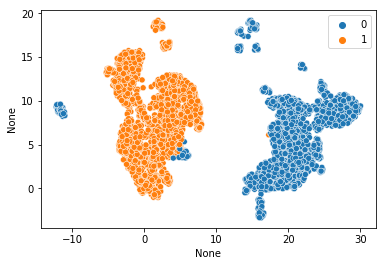


Number of neighbors: 130, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


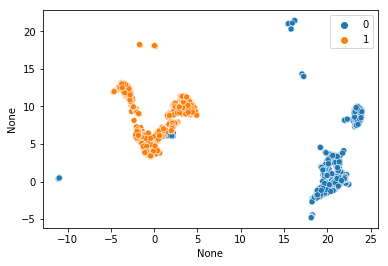


Number of neighbors: 130, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


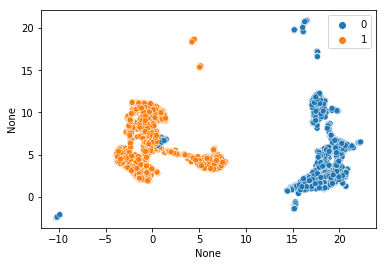


Number of neighbors: 130, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


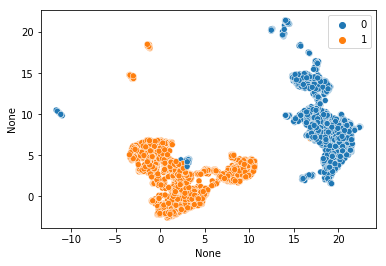


Number of neighbors: 130, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


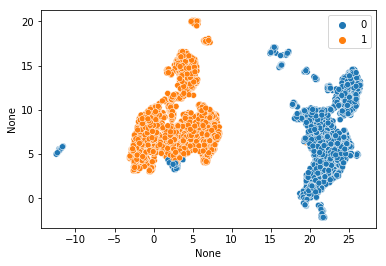


Number of neighbors: 130, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


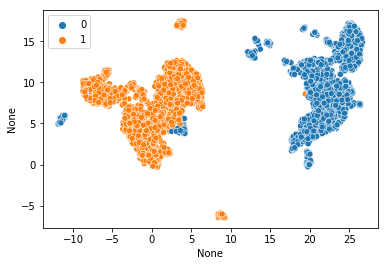


Number of neighbors: 130, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


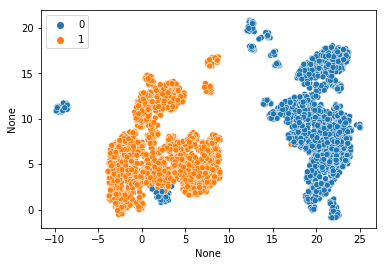


Number of neighbors: 160, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


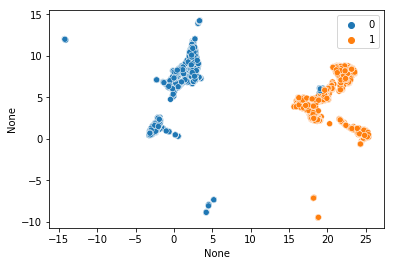


Number of neighbors: 160, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


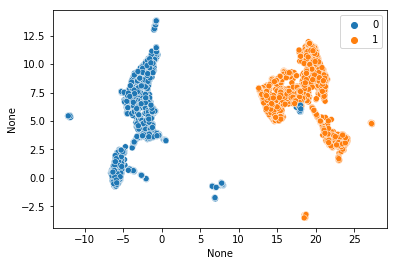


Number of neighbors: 160, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


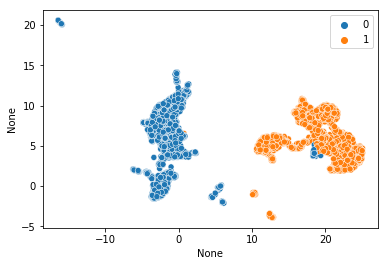


Number of neighbors: 160, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


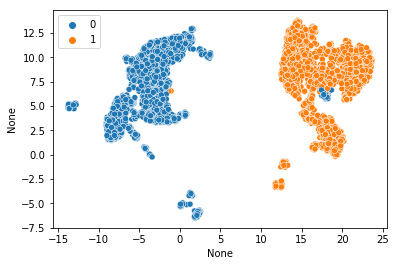


Number of neighbors: 160, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


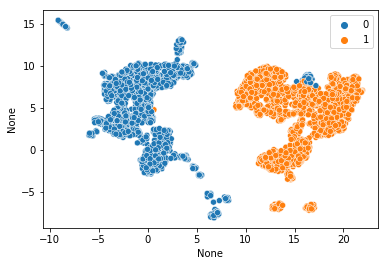


Number of neighbors: 160, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


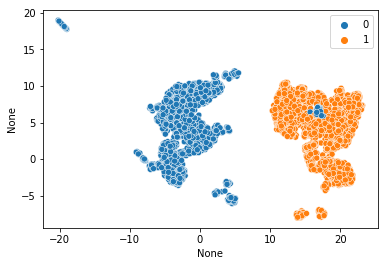


Number of neighbors: 190, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


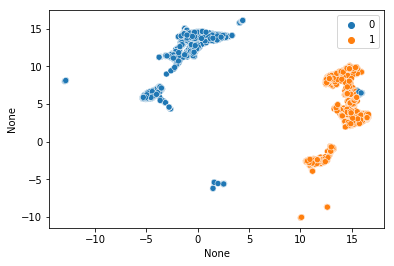


Number of neighbors: 190, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


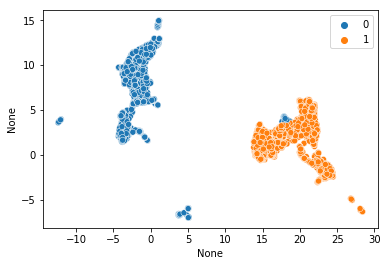


Number of neighbors: 190, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


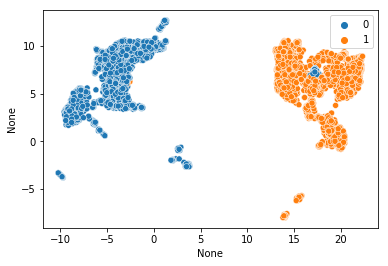


Number of neighbors: 190, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


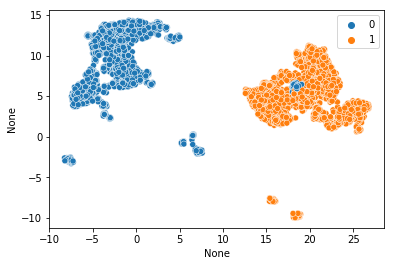


Number of neighbors: 190, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


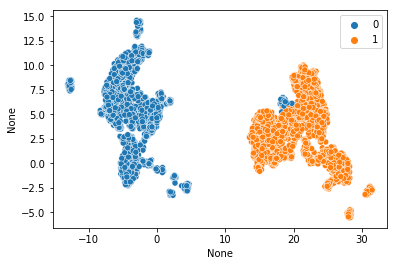


Number of neighbors: 190, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


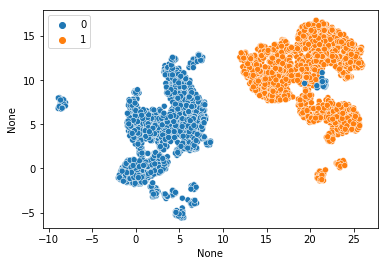

In [32]:
stacked_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 
                          'vader_pos', 'vader_compound'] \
                    + n_comps_LDA_df.columns.tolist()[:-1] \
                    + ['NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0', 'XGB_prob1'] 

# _ = get_UMAP_res(merged_df, stacked_features, best_nc_labels)



#### UMAP and ground truth 


Number of neighbors: 10, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


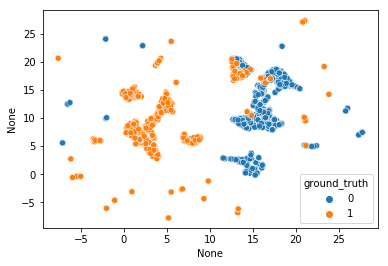


Number of neighbors: 10, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


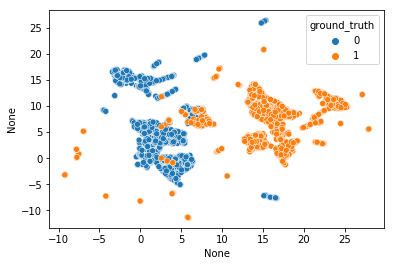


Number of neighbors: 10, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


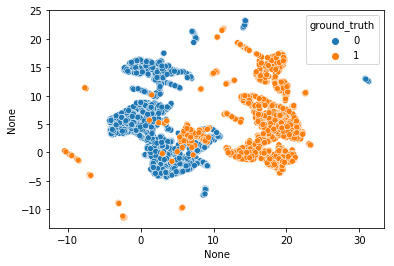


Number of neighbors: 10, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


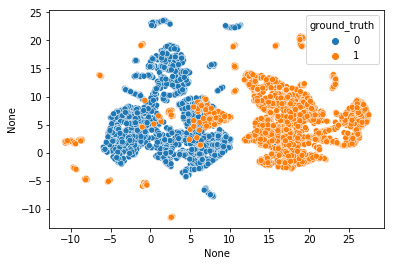


Number of neighbors: 10, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


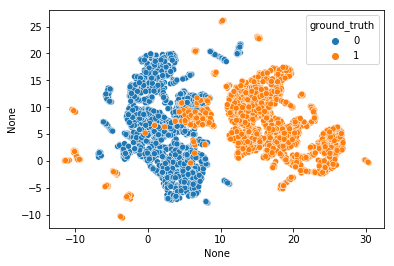


Number of neighbors: 10, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


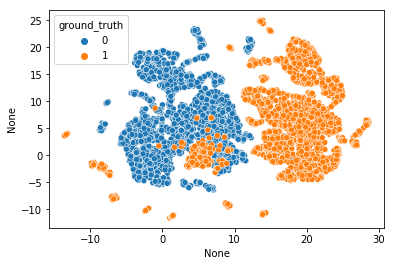


Number of neighbors: 40, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


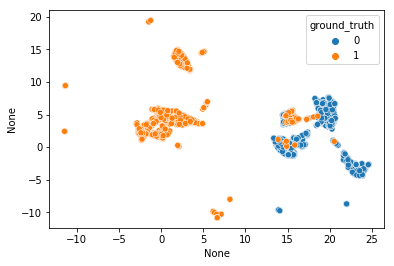


Number of neighbors: 40, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


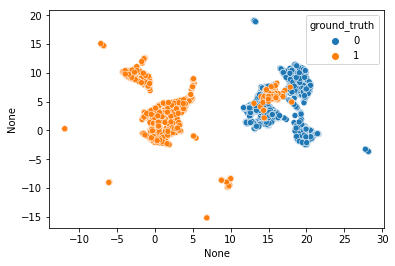


Number of neighbors: 40, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


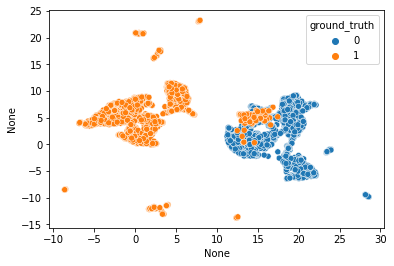


Number of neighbors: 40, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


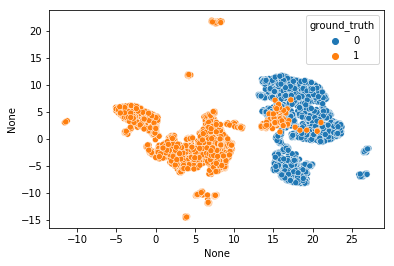


Number of neighbors: 40, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


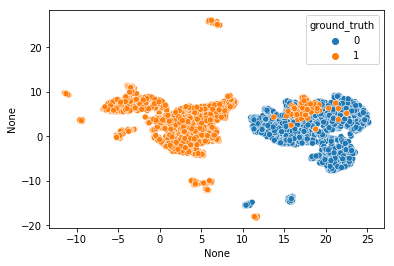


Number of neighbors: 40, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


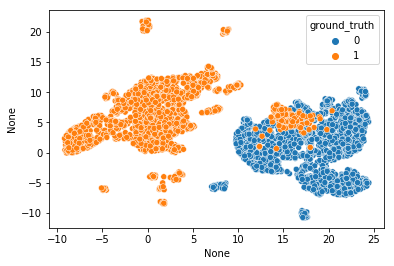


Number of neighbors: 70, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


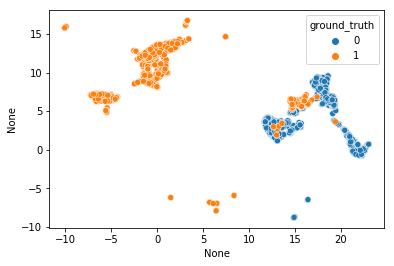


Number of neighbors: 70, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


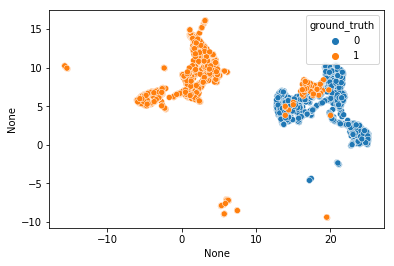


Number of neighbors: 70, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


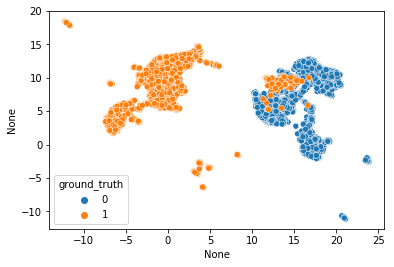


Number of neighbors: 70, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


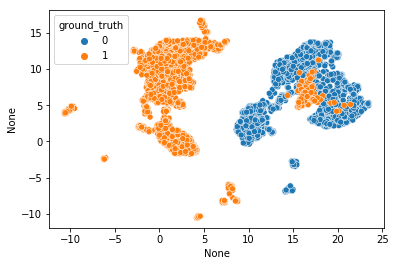


Number of neighbors: 70, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


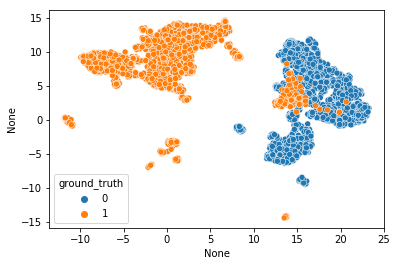


Number of neighbors: 70, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


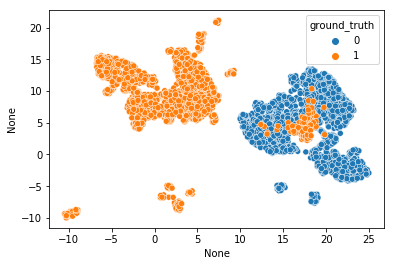


Number of neighbors: 100, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


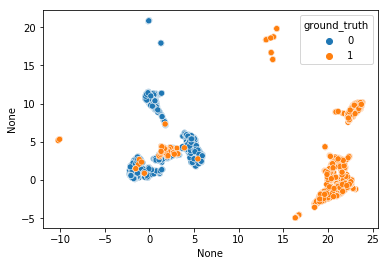


Number of neighbors: 100, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


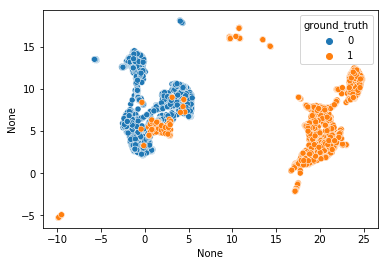


Number of neighbors: 100, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


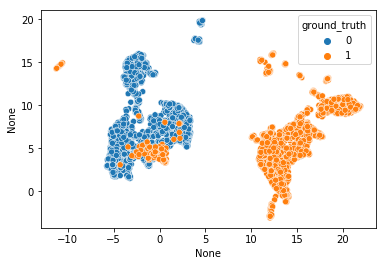


Number of neighbors: 100, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


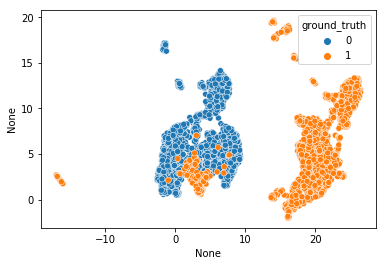


Number of neighbors: 100, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


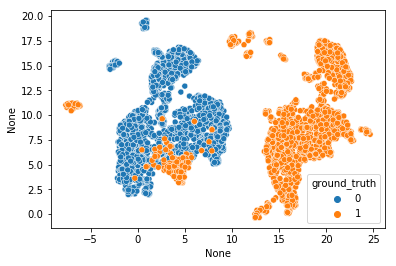


Number of neighbors: 100, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


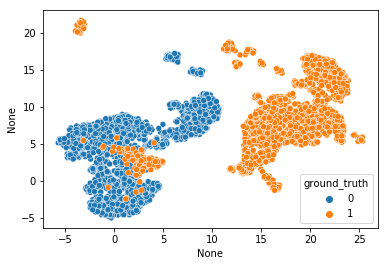


Number of neighbors: 130, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


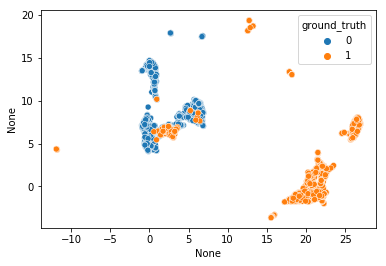


Number of neighbors: 130, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


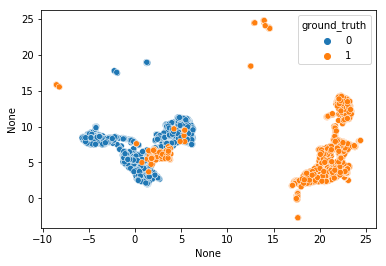


Number of neighbors: 130, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


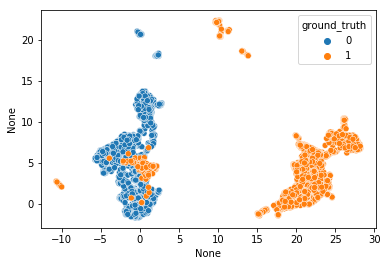


Number of neighbors: 130, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


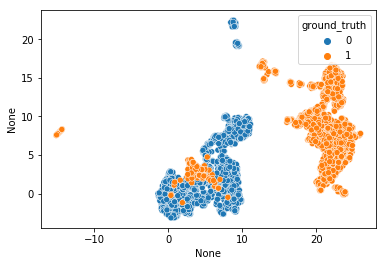


Number of neighbors: 130, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


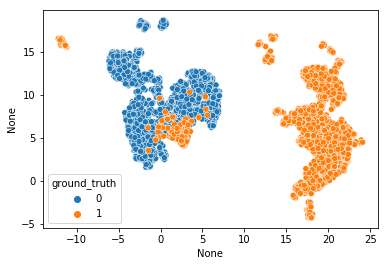


Number of neighbors: 130, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


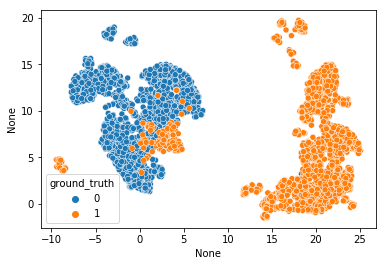


Number of neighbors: 160, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


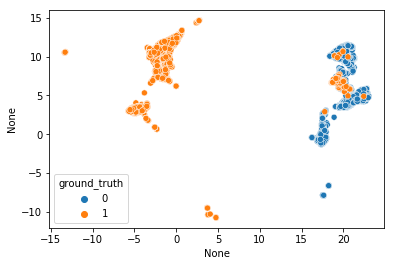


Number of neighbors: 160, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


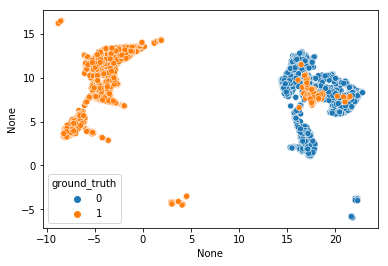


Number of neighbors: 160, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


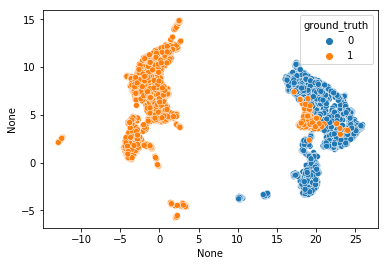


Number of neighbors: 160, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


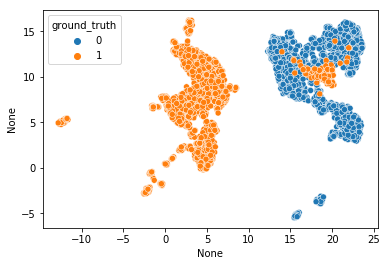


Number of neighbors: 160, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


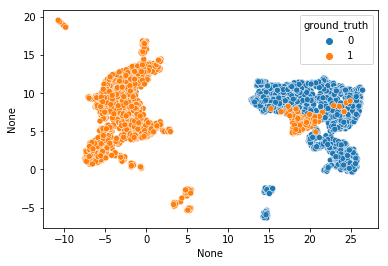


Number of neighbors: 160, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


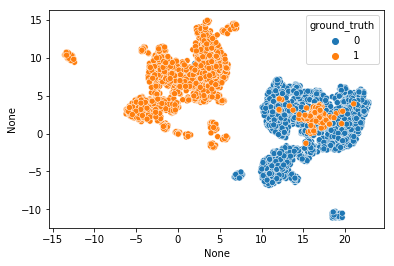


Number of neighbors: 190, minimum distance: 0.1


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


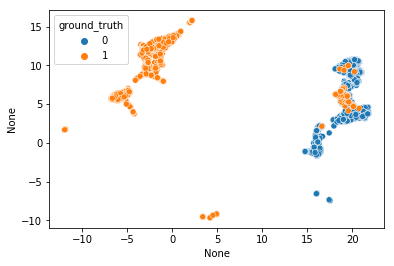


Number of neighbors: 190, minimum distance: 0.3


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


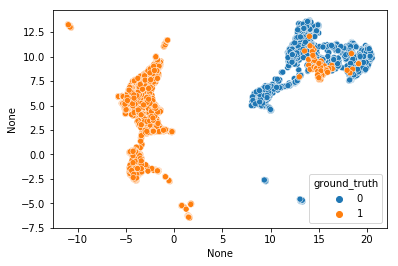


Number of neighbors: 190, minimum distance: 0.5


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


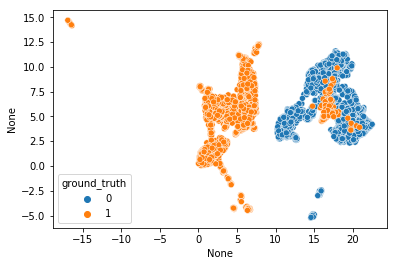


Number of neighbors: 190, minimum distance: 0.7


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


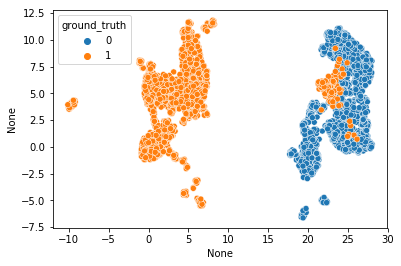


Number of neighbors: 190, minimum distance: 0.8


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


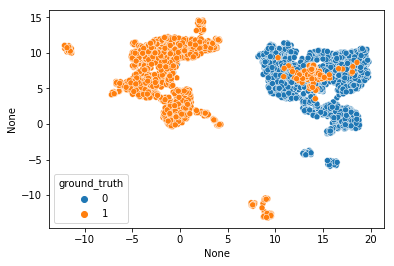


Number of neighbors: 190, minimum distance: 0.95


/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


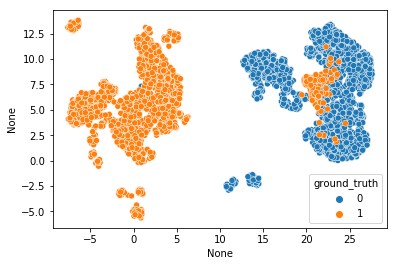

In [33]:
stacked_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 
                          'vader_pos', 'vader_compound'] \
                    + n_comps_LDA_df.columns.tolist()[:-1] \
                    + ['NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0', 'XGB_prob1'] 

hue_ = merged_df["ground_truth"]

_ = get_UMAP_res(merged_df, stacked_features, hue_)

#### Final UMAP, K-means and Ground truth plot 

/Users/iTaufeeq/anaconda3/envs/socialMM/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


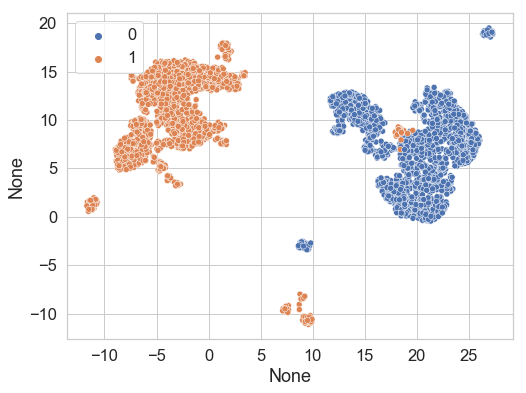

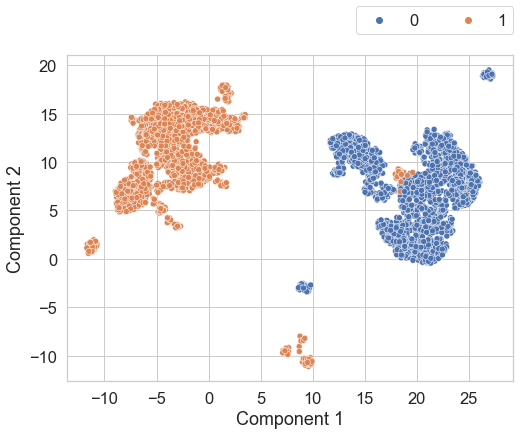

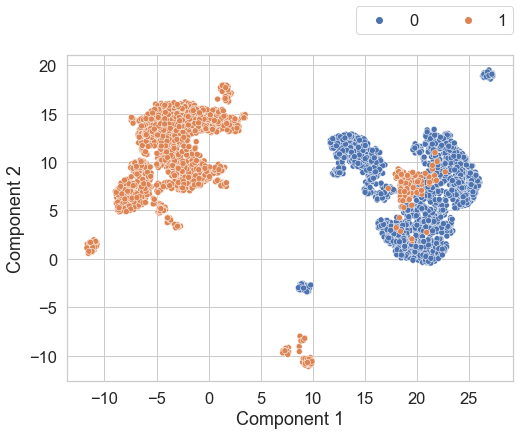

In [20]:
stacked_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 
                          'vader_pos', 'vader_compound'] \
                    + n_comps_LDA_df.columns.tolist()[:-1] \
                    + ['NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0', 'XGB_prob1'] 

n_neigh = 190 
min_dist = 0.95
labels = best_nc_labels
latent_df = get_UMAP_w_fixed_params(merged_df, stacked_features, n_neigh, min_dist, labels)

# K-means 
h = best_nc_labels 
wrt_fig_dir = "../figs/clus_perfs/"
plot_name = "UMAP_latentSpace_KMeans.jpg" 
_ = plot_latent_space(latent_df, h, wrt_fig_dir, plot_name)


# ground truth 
h = merged_df["ground_truth"] 
wrt_fig_dir = "../figs/clus_perfs/"
plot_name = "UMAP_latentSpace_groundTruth.jpg" 
_ = plot_latent_space(latent_df, h, wrt_fig_dir, plot_name)

## LDA  for topic modeling

In [17]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v3.csv")
print(df.columns)

BERT_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_BERT_df_v4.csv")
print(BERT_df.shape)

# TF_IDF_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_TF_IDF_df_v4.csv")
# print(TF_IDF_df.shape)

Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')
(3201, 769)


In [18]:
merged_df = pd.merge(df[["folds", "ID"]], BERT_df, on=["ID"], sort=True)

In [19]:
print(merged_df.shape)

BERT_features = BERT_df.columns.tolist()[:-1]
model_type = "LDA"

res_df = train_models.train_n_cv_valid_LDA(merged_df, BERT_features, model_type)

(3201, 770)
[2, 3, 1, 4]
(2400, 770)


ValueError: Negative values in data passed to LatentDirichletAllocation.fit

In [ ]:
n_comps_LDA_df = pd.DataFrame(res_df)

In [ ]:
n_comps_LDA_df.to_csv("../data/stack_files/balanced_pro_n_anti_mask_LDA10_df_v4.csv", index=False, header=True)

In [ ]:
n_comps_LDA_df.tail()

## Context model with LDA 

In [60]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v4.csv")

n_comps_LDA_df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_LDA10_df_v4.csv")

cls_probs_df = pd.read_csv("../data/cls_pred_files/probs_BERT.csv") 

print(df.shape)
print(n_comps_LDA_df.columns)
print(cls_probs_df.columns)

(3201, 24)
Index(['LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3', 'LDA_comp_4', 'LDA_comp_5',
       'LDA_comp_6', 'LDA_comp_7', 'LDA_comp_8', 'LDA_comp_9', 'LDA_comp_10',
       'ID'],
      dtype='object')
Index(['NB_prob0', 'NB_prob1', 'ID', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0',
       'XGB_prob1'],
      dtype='object')


In [61]:
merged_df = pd.merge(df, n_comps_LDA_df, on=["ID"], sort=True)
merged_df = pd.merge(merged_df, cls_probs_df, on=["ID"], sort=True)

print(merged_df.shape)
print(merged_df.columns)

(3201, 40)
Index(['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'User Id', 'User Name',
       'User Location', 'Tweet Coordinates', 'Place Info', 'Country',
       'Hashtags', 'Retweets', 'Favorites', 'Language', 'Source',
       'Replied Tweet Id', 'Replied Tweet User Id', 'month', 'ground_truth',
       'ID', 'folds', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3', 'LDA_comp_4', 'LDA_comp_5',
       'LDA_comp_6', 'LDA_comp_7', 'LDA_comp_8', 'LDA_comp_9', 'LDA_comp_10',
       'NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0',
       'XGB_prob1'],
      dtype='object')


In [66]:
stacked_features = ['Retweets', 'Favorites', 'vader_neg', 'vader_neu', 
                          'vader_pos', 'vader_compound'] \
                        + ['NB_prob0', 'NB_prob1', 'KNN_prob0', 'KNN_prob1', 'XGB_prob0', 'XGB_prob1'] 
#                         + n_comps_LDA_df.columns.tolist()[:-1] \

# print(context_n_LDA_features)

# model_type = "XGB"
# res_df, _ = train_models.train_n_cv_valid_models(merged_df, context_n_LDA_features, model_type)


feature_type = "interpret"
res_df = run_all_cls(merged_df, stacked_features, feature_type)

res_df.tail()

[1, 2, 3, 4]
[1, 2, 3, 4]
[1, 2, 3, 4]


index  Antimask   Promask accuracy macro avg weighted avg metrics_names  \
31      9   0.97543  0.964377     0.97  0.969903         0.97        recall   
32     10   0.97066  0.969309     0.97  0.969985     0.969997      f1-score   
33     12  0.960976  0.976923  0.96875  0.968949      0.96889     precision   
34     13  0.977667  0.959698  0.96875  0.968683      0.96875        recall   
35     14   0.96925  0.968234  0.96875  0.968742     0.968746      f1-score   

   cls_model_name  
31            XGB  
32            XGB  
33            XGB  
34            XGB  
35            XGB

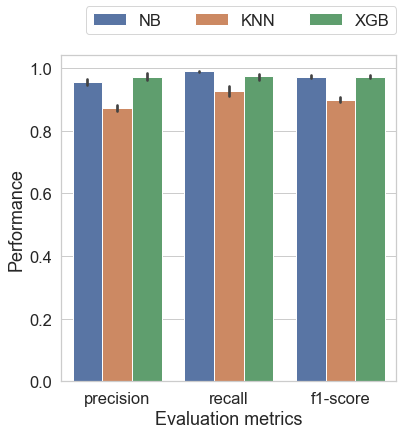

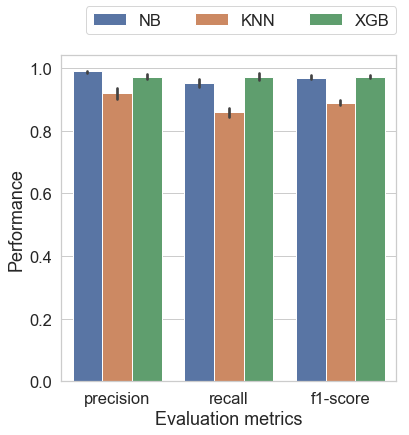

In [67]:
feature_type = "stacked"
_ = plot_res_n_save(res_df, "../figs/cls_perfs/", feature_type)

In [42]:
res_df.head()

0         1  accuracy macro avg weighted avg metrics_names  \
0  0.985037  0.954887      0.97  0.969962     0.970452     precision   
1  0.956416  0.984496      0.97  0.970456         0.97        recall   
2  0.970516  0.969466      0.97  0.969991     0.970008      f1-score   
3       413       387      0.97       800          800       support   
4  0.949881   0.97644  0.962547   0.96316     0.962945     precision   

  cls_model_name  
0            XGB  
1            XGB  
2            XGB  
3            XGB  
4            XGB

#### Feature Importance 

## Relatoinship between polarities and tweet class (antimask vs. promask)

In [2]:
df = pd.read_csv("../data/stack_files/balanced_pro_n_anti_mask_df_v4.csv")

features = ['ground_truth', 'Retweets', 'Favorites', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

df2 = df[features]

In [3]:
df2.head()

ground_truth  Retweets  Favorites  vader_neg  vader_neu  vader_pos  \
0             0      1314          0        0.0      1.000      0.000   
1             0         3          3        0.0      0.430      0.570   
2             1         9         63        0.0      0.669      0.331   
3             1     36370          0        0.0      0.902      0.098   
4             0         3          0        0.0      0.580      0.420   

   vader_compound  
0          0.0000  
1          0.6084  
2          0.8725  
3          0.0772  
4          0.8860

In [18]:
# for f in features:
#     # call the function in here 
#     h = "ground_truth"
#     _ = sns.histplot(df2, x=f, hue=h)
    

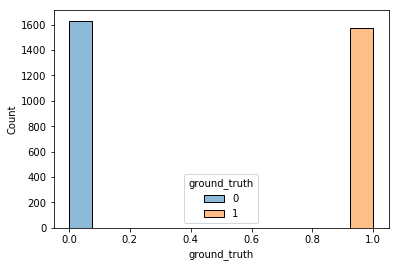

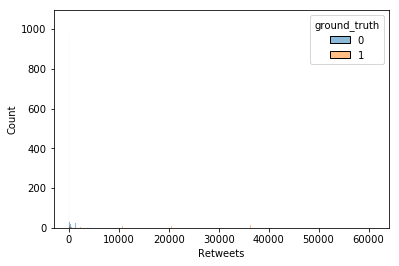

In [ ]:
# sns.histplot(x=df2["Retweets"].astype(float), hue=df2["ground_truth"], log_scale=True)

for f in features:
    plt.clf()
    x_ = np.log(df2[f].astype(float) + 2)
#     x_ = df2[f].astype(int)
    sns.histplot(x=x_, hue=df2["ground_truth"])
    
    wrt_fig_dir = "../figs/meta/"
    plt_name = "hist_" + f + ".jpg" 
#     _ = plot_latent_space(latent_df, h, wrt_fig_dir, plt_name)
    
    plt.savefig(os.path.join(wrt_fig_dir, plt_name),
            bbox_inches = 'tight', # get rid of the white space
            pad_inches = 0.05, # ref: https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib/27227718
            dpi=300)

    plt.show()

In [10]:
col_name = "Retweets"

x_ = np.log(df[col_name].astype(float) + 1)
h_ = df["ground_truth"]

x_axis_label = col_name 
y_axis_label = "Frequency"

plotting.draw_histPlot(x_, h_, x_axis_label, y_axis_label)

TypeError: draw_histPlot() missing 1 required positional argument: 'y_axis_label'

In [7]:
def draw_histPlot(x_, h_, x_axis_label, y_axis_label):
    plt.clf()

    plt.rcParams["figure.figsize"] = [6, 4] # [10, 5] looks better though
    fig, ax = plt.subplots()

    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")

    sns.histplot(x=x_, hue=h_)

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    return 0 



0

<Figure size 432x288 with 0 Axes>

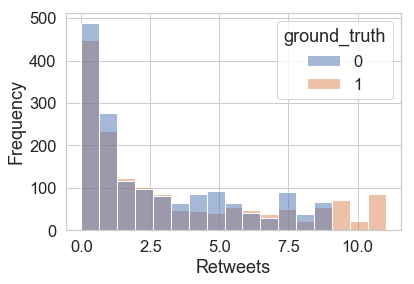

In [11]:
# Retweets 

draw_histPlot(x_, h_, x_axis_label, y_axis_label)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

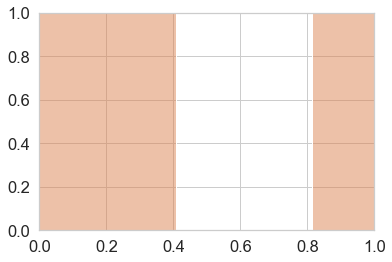

In [15]:
col_name = "Favorites"

x_ = df[col_name].astype(float) # np.log(df[col_name].astype(float) + 10**3)
h_ = df["ground_truth"]

x_axis_label = col_name 
y_axis_label = "Frequency"

draw_histPlot(x_, h_, x_axis_label, y_axis_label)